In [1]:
%matplotlib widget
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

%matplotlib widget
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def json_fn_to_dict(fn):
    with open(fn, "r") as f:
        d = json.load(f)

    d["log_name"] = fn.stem
    d["x"] = pd.to_datetime(d["x"])    
    
    if "HPTED" in fn.stem:
        d["model"] = "TunedRF"

    return d

def add_tc(d):
    trained_on = d["trained_on"][0]

    if "_TC=" not in trained_on:
        tc = 1
    else:
        # h=18_residential_2018_WITH_PV_SFH15_TC=48_2018.csv"
        tc_str = trained_on.split("_")
        tc_str = [foo for foo in tc_str if "TC=" in foo][0]
        tc = int(tc_str[3:])


    d["time_compression"] = [tc]
    return d

def calc_core_corrected_time_to_fit(d):

    model_type = d["model"][0]
    time_to_fit = d["time_to_fit"][0]

    core_corrected_time_to_fit = ...
    if model_type == "CustomLSTM":
        core_corrected_time_to_fit = time_to_fit * 5.5  # experiments showed that LSTM used approximately 550% cores 

    elif model_type == "CustomRandomForest":
        core_corrected_time_to_fit = time_to_fit * 6.5 

    elif model_type == "TunedRF":
        core_corrected_time_to_fit = time_to_fit * 10 

    elif model_type == "CustomSARIMAX":

        dt_str_format = "'%a %b %d %H:%M:%S %Y'"
        time_of_start = d['time_before_fit'][0]
        time_of_start = datetime.datetime.strptime(time_of_start, dt_str_format)

        time_when_n_cores_changed = datetime.datetime(2022, 11, 18, 9, 10)

        if time_of_start < time_when_n_cores_changed:
            core_corrected_time_to_fit = time_to_fit * 16.5

        else:
            core_corrected_time_to_fit = time_to_fit * 39.5

    elif model_type == "CustomProphet":
        core_corrected_time_to_fit = time_to_fit * 1.5 

    elif model_type == "CustomNaiveYesterday":
        core_corrected_time_to_fit = time_to_fit * 1
    
    elif model_type == "CustomNaiveLastWeek":
        core_corrected_time_to_fit = time_to_fit * 1

    else:
        raise NotImplementedError(f"Error! {model_type} is not implemented")

    d["core_corrected_time_to_fit"] = [core_corrected_time_to_fit]

    return d

def add_metric(d, metric_name, metric_func):
    y, yhat = d["y"][0], d["yhat"][0]

    train_y, train_yhat = d["train_y"][0], d["train_yhat"][0]
    test_y, test_yhat = d["test_y"][0], d["test_yhat"][0]

    d[f"{metric_name}"] = [metric_func(y, yhat)]
    d[f"{metric_name}_train"] = [metric_func(train_y, train_yhat)]
    d[f"{metric_name}_test"] = [metric_func(test_y, test_yhat)]

    return d

def add_split_train_eval(d):
    x, y, yhat = d["x"][0], d["y"][0], d["yhat"][0]
    # assert len(y) == len(yhat)
    n = int(len(y)*d['train_eval_split'][0])

    train_x, train_y, train_yhat = x[:n], y[:n], yhat[:n]
    test_x, test_y, test_yhat = x[n:], y[n:], yhat[n:]

    train_y = [float(_y) for _y in train_y]
    train_yhat = [float(_y) for _y in train_yhat]
    test_y = [float(_y) for _y in test_y]
    test_yhat = [float(_y) for _y in test_yhat]

    d["train_x"] = [train_x]
    d["train_y"] = [train_y]
    d["train_yhat"] = [train_yhat]

    d["test_x"] = [test_x]
    d["test_y"] = [test_y]
    d["test_yhat"] = [test_yhat]

    return d

def add_errors(d):
    for prefix in ["", "test_", "train_"]:
        y, yhat = d[f"{prefix}y"][0], d[f"{prefix}yhat"][0]
        error = [_y - _yh for _y, _yh in zip(y, yhat)]
        d[f"{prefix}error"] = [error]
        error = np.array(error)

        d[f"{prefix}error_mean"] = float(np.mean(error))
        d[f"{prefix}error_std"] = float(np.std(error))

    return d

def add_metrics(d):
    d = add_metric(d, metric_name="r2", metric_func=r2_score)
    d = add_metric(d, metric_name="mse", metric_func=mean_squared_error)
    d = add_metric(d, metric_name="mae", metric_func=mean_absolute_error)
    d = add_metric(d, metric_name="mape", metric_func=mean_absolute_percentage_error)

    return d
  
def add_binary_classification(d):
    trained_on = d["trained_on"][0]

    if "industrial" in trained_on:
        classification = "industrial"
    elif "residential" in trained_on:
        classification = "residential"
    elif "aggregate" in trained_on:
        classification = "aggregate"

    else:
        raise NotImplementedError(f"trained_on = {trained_on}")

    d["binary_classification"] = [classification]
    return d

def add_trinary_classification(d):
    trained_on = d["trained_on"][0]

    if "industrial" in trained_on:
        classification = "industrial"
    elif "NO_PV" in trained_on:
        classification = "NO_PV"
    elif "WITH_PV" in trained_on:
        classification = 'WITH_PV'
        
    elif "aggregate" in trained_on:
        classification = "aggregate"

    else:
        raise NotImplementedError(f"trained_on = {trained_on}")

    d["trinary_classification"] = [classification]
    return d
    
def prep_dict(d):
    d = {k: [v] for k, v in d.items()}

    d["trained_on"] = [Path(d["data_source_path"][0]).stem]

    d["log_ID"] = [int(d["log_name"][0].split("_")[0])]

    d = add_file_end(d)

    d = add_horizon(d)

    d = add_binary_classification(d)

    d = add_trinary_classification(d)

    d = calc_core_corrected_time_to_fit(d)

    d = add_split_train_eval(d)

    d = add_errors(d)
    
    d = add_metrics(d)

    d = update_model(d)

    d = add_tc(d)

    return d

def update_model(d):
    model = d["model"][0]

    if model.startswith("Custom"):
        model = model[6:]

    d["model"] = [model]
    return d

def add_horizon(d):
    x = d["trained_on"][0] #  x = 'h=4_industrial_2016_LG_4'
    
    x = x.split("_")[0] # x = "h=4"

    x = x[2:]  # x = "4"

    x = int(x)

    d["horizon"] = [x]

    return d

def add_file_end(d):
    trained_on = d["trained_on"][0]

    foo = trained_on.split("_")

    foo = ("_").join(foo[1:])

    d["file_end"] = [foo]

    return d


def lazy_prep_dict(fn):
    d = json_fn_to_dict(fn)
    d = prep_dict(d)

    return d


def dicts_to_df(dicts):
    df = pd.DataFrame(dicts[0])

    for d in dicts[1:]:
        # make the new dataframe
        new_df = pd.DataFrame(d)

        # if not all columns of the new df are in the old df:
        for c in new_df.columns:
            if c not in df.columns:
                df[c] = [np.nan]*len(df)

        # if not all columns of the old df are in the new df:
        for c in df.columns:
            if c not in new_df.columns:
                new_df[c] = [np.nan]

        assert all(c in new_df.columns for c in df)
        assert all(c in df.columns for c in new_df)

        df = pd.concat([df, new_df], ignore_index=True)

    return df

def string_to_list_of_numbers(string):
    assert string[0] == "["
    assert string[-1] == "]"
    string = string[1:-1]
    strings = string.split(",")

    floats = [float(string) for string in strings]
    return floats

def string_to_list_of_datetimes(string):
    dt_str_format = "'%Y-%m-%d %H:%M:%S'"
    string = string.split("]")[0]
    string = string.split("[")[1]

    strings = string.split(",")
    strings = [string.strip("...") for string in strings]
    strings = [string.strip("\n") for string in strings]
    strings = [string.strip(" ") for string in strings]

    dts = [datetime.datetime.strptime(dt_str, dt_str_format) for dt_str in strings]
    return dts
    
def fix_loaded_df(df):
    df = df.drop(columns='Unnamed: 0')
    df["x"] = [string_to_list_of_datetimes(x) for x in df["x"]]
    df["y"] = [string_to_list_of_numbers(y) for y in df["y"]] 
    df["yhat"] = [string_to_list_of_numbers(y) for y in df["yhat"]] 
     
    return df

In [2]:
def load_source_df(fn):
    df = pd.read_csv(fn)
    df["datetimes"] = pd.to_datetime(df["datetimes"])
    return df

def plot_source_df(df, ax, label=None, mavg=0):    
    x = df["datetimes"]
    y = df["load_profile"]

    if mavg:
        y = y.rolling(mavg).mean()[mavg-1:]
        x = x.iloc[mavg-1:]
    

    ax.plot(x, y, label=label)
    ax.set_ylabel("load profile")
    ax.set_xlabel("datetimes")
    ax.grid()

    return ax

In [3]:
FIG_TYPE = "presentation"
SAVE_FIGS = True

if FIG_TYPE == "paper":
    # stylesheet
    mpl.rcParams["lines.linewidth"] = 1.5
    mpl.rcParams["figure.figsize"] = (5, 3)

elif FIG_TYPE == "presentation": # presentation
    # stylesheet
    mpl.rcParams["lines.linewidth"] = 2.5
    mpl.rcParams["figure.figsize"] = (9, 6)
    mpl.rcParams["axes.titlesize"] = 24
    mpl.rcParams["axes.labelsize"] = 20
    mpl.rcParams["xtick.labelsize"] = 14
    mpl.rcParams["ytick.labelsize"] = 14
else:
    raise NotImplementedError

# consistency mapping
COLORS = {"LSTM": "green", "Prophet": "orange", "RandomForest": "red", "Old RF": "red", "New RF": "cyan", "TunedRF": "cyan", "SARIMAX": "red", "NaiveLastWeek": "navy", "NaiveYesterday": "magenta"}
MARKERS = {"LSTM": "x", "Prophet": "o", "RandomForest": "d", "TunedRF": ".", "SARIMAX": ".", "NaiveLastWeek": "^", "NaiveYesterday": "v"}

# 
FIGURE_SAVE_DIR = Path(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\03_Report\Figures")

# LOAD DATASET SAMPLES

In [4]:
MAIN_DATASET_DIR = Path(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\00_Programming\forecasting\datasets")
TRAIN_DIR = MAIN_DATASET_DIR / "train"

## industrial dataset sample


In [5]:
INDUSTRIAL_DIR = TRAIN_DIR / "industrial"

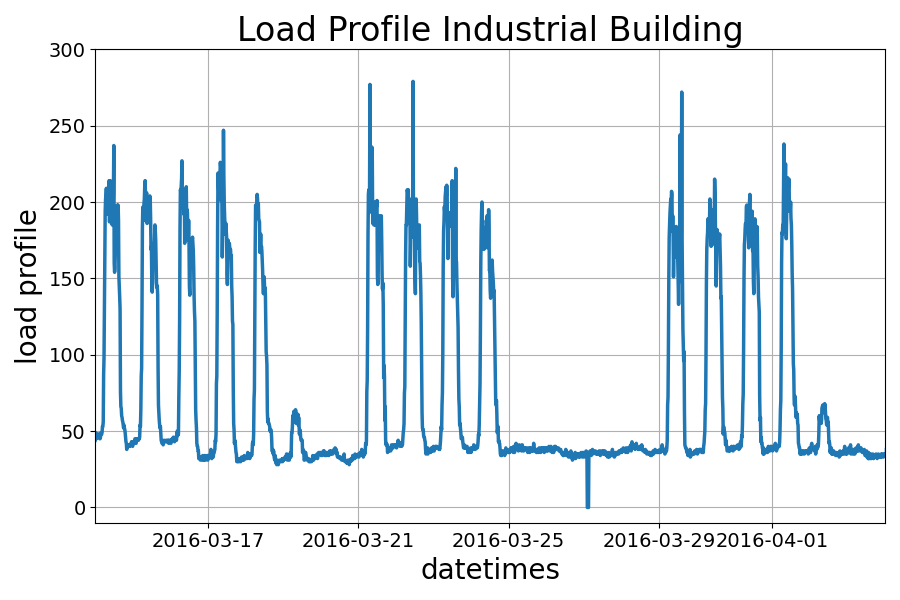

In [37]:
industrial_fn = INDUSTRIAL_DIR / "h=1_industrial_2016_LG_1.csv"
ind_df = load_source_df(industrial_fn)

fig, ax = plt.subplots()
plot_source_df(ind_df, ax)

ax.set_xlim([ind_df["datetimes"][24*4*3 + 24*4*7*10], ind_df["datetimes"][24*4*3 + 24*4*7*13]])
ax.set_ylim([-10, 300])
ax.set_title("Load Profile Industrial Building")
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_industrial_load_profile")

## Residential dataset sample

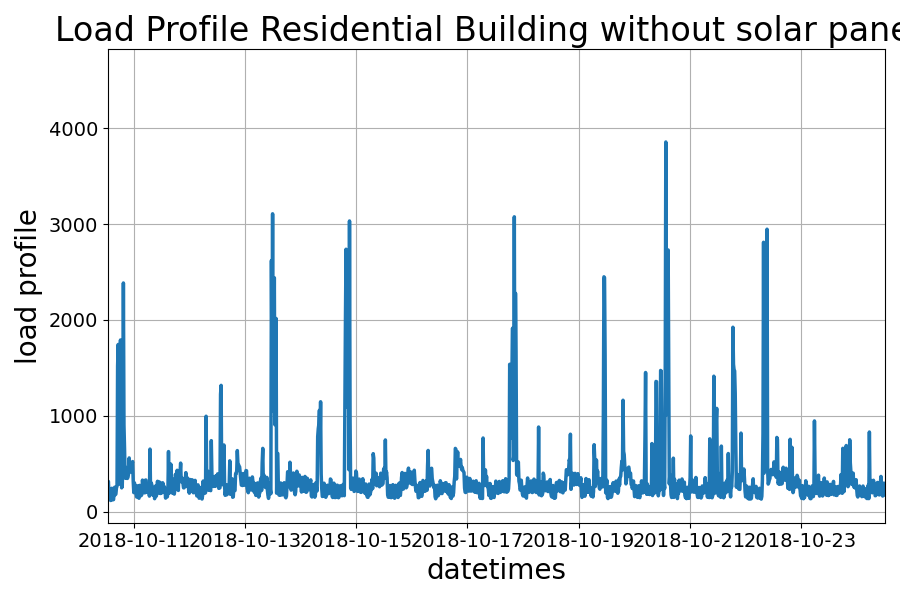

In [38]:
RES_DIR = TRAIN_DIR / "residential_no_pv"

res_fn = RES_DIR / "h=1_residential_2018_NO_PV_SFH5_2018.csv"
res_df = load_source_df(res_fn)

fig, ax = plt.subplots()
plot_source_df(res_df, ax)

ax.set_xlim([res_df["datetimes"][24*4*7*5], res_df["datetimes"][24*4*7*5+24*4*14]])
#ax.set_ylim([0, 1000])
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)
ax.set_title("Load Profile Residential Building without solar panels")
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_residential_without_pv_load_profile")


## With PV Samples

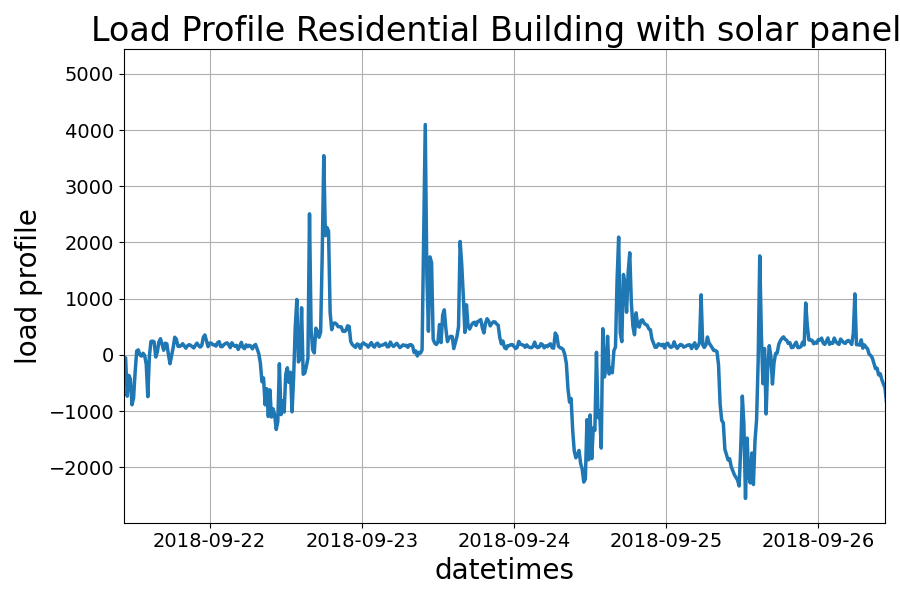

In [39]:
RES_DIR = TRAIN_DIR / "residential_with_pv"
res_fn = RES_DIR / "h=1_residential_2018_WITH_PV_SFH13_2018.csv"
res_df = load_source_df(res_fn)

fig, ax = plt.subplots()
plot_source_df(res_df, ax)

ax.set_xlim([res_df["datetimes"][24*4*7*5], res_df["datetimes"][24*4*7*5+24*4*5]])
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)
ax.set_title("Load Profile Residential Building with solar panels")
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_residential_with_pv_load_profile")

# LOAD LOGS

In [4]:
log_dir = Path(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\00_Programming\forecasting\logs")
fns = [fn for fn in log_dir.iterdir() if fn.is_file()]

ds = [lazy_prep_dict(fn) for fn in fns]
COMPLETE_DF = dicts_to_df(ds)

C:\Users\Flin\AppData\Local\Temp\ipykernel_9136\3091847411.py:274: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df, new_df], ignore_index=True)


In [5]:
COMPLETE_DF.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'weekly_seasonality', 'daily_seasonality',
       'only_fit_using_last_n_weeks', 'rolling_predict_rows_to_refit',
       'n_cores', 'rolling_prediction', 'tiny_test', 'os', 'time_at_saving',
       'log_name', 'trained_on', 'log_ID', 'file_end', 'binary_classification',
       'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
       'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'error',
       'error_mean', 'error_std', 'test_error', 'test_error_mean',
       'test_error_std', 'train_error', 'train_error_mean', 'train_error_std',
       'r2', 'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
       'time_compression', 'n_estimators', 'n_jobs', 'max_features',
       'max_samples', 'ts2row_history_window', 'n_train_epoc

In [6]:
COMPLETE_DF["model"].unique()

array(['Prophet', 'TunedRF', 'RandomForest', 'LSTM', 'SARIMAX',
       'NaiveYesterday', 'NaiveLastWeek'], dtype=object)

## Plot stage 1 time-to-fit

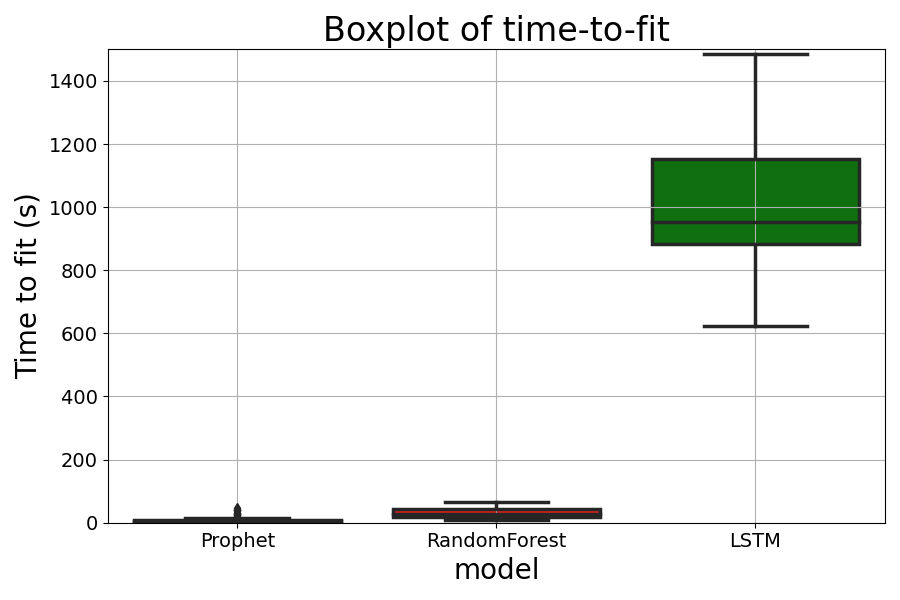

In [40]:
df = COMPLETE_DF.copy(deep=True)

# remove all with ID > 820 (since that's when HPTD)

df = df[df["log_ID"] <= 820]

# remove all that are not Prophet, Random Forest, or LSTM
df = df[df["model"].isin(["Prophet", "RandomForest", "LSTM"])]

fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="model", y="core_corrected_time_to_fit", palette=COLORS, ax=ax)
ax.grid()
ax.set_title("Boxplot of time-to-fit")
ax.set_ylabel("Time to fit (s)")
ax.set_ylim([0, 1500])
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_ttf_a")


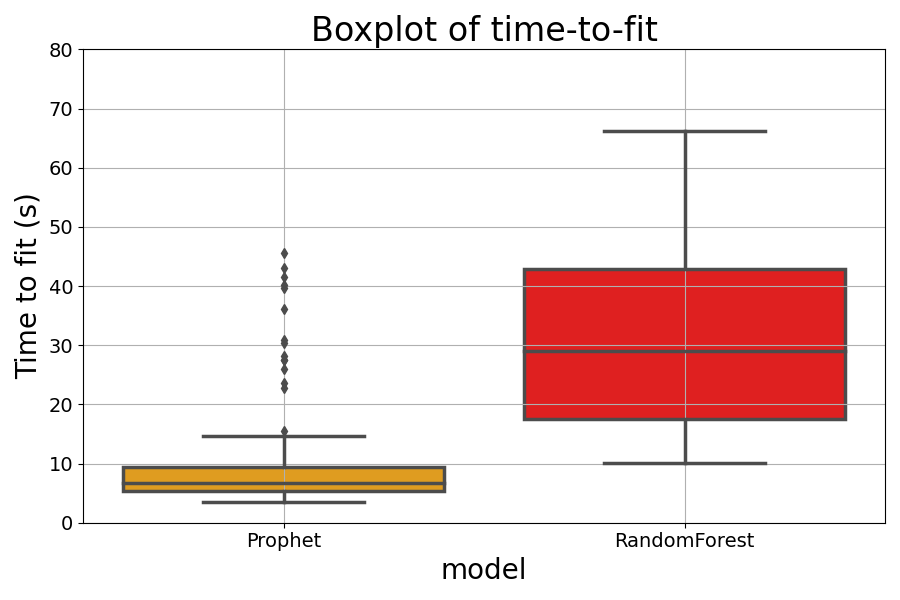

In [41]:
df = COMPLETE_DF.copy(deep=True)

# remove all with ID > 820 (since that's when HPTD)

df = df[df["log_ID"] <= 820]

# remove all that are not Prophet, Random Forest, or LSTM
df = df[df["model"].isin(["Prophet", "RandomForest"])]

fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="model", y="core_corrected_time_to_fit", palette=COLORS, ax=ax)
ax.grid()
ax.set_title("Boxplot of time-to-fit")
ax.set_ylabel("Time to fit (s)")
ax.set_ylim([0, 80])
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_ttf_b")

## Plot stage 1 MSE

In [8]:
df = COMPLETE_DF.copy(deep=True)

# remove all with ID > 820 (since that's when HPTD)

df = df[df["log_ID"] <= 820]

# remove all that are not Prophet, Random Forest, or LSTM
df = df[df["model"].isin(["Prophet", "RandomForest", "LSTM", 'NaiveYesterday'])]

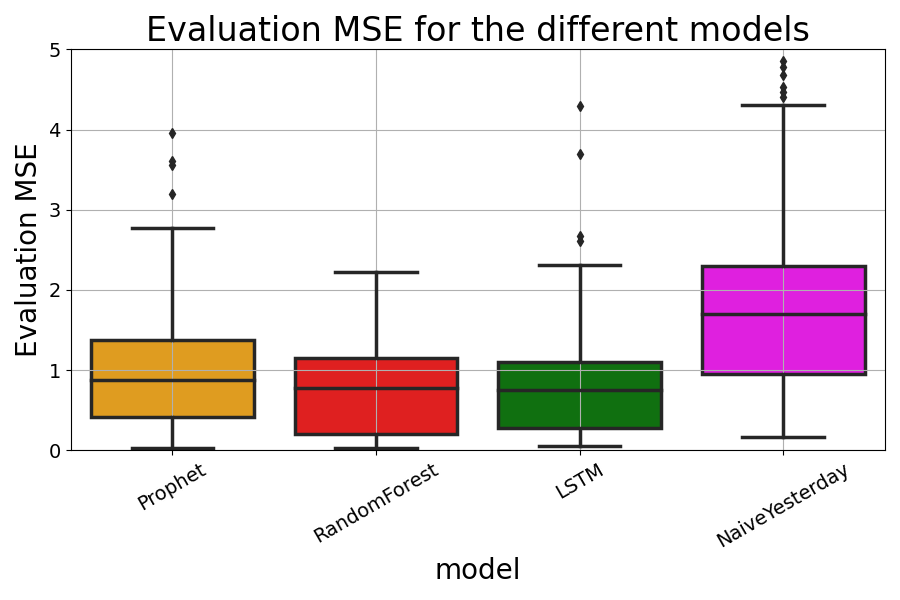

In [9]:
fig, ax = plt.subplots()

ax = sns.boxplot(data=df, x="model", y="mse_test", palette=COLORS, ax=ax)
ax.grid()
ax.set_ylim([0, 5])
ax.set_ylabel("Evaluation MSE")
ax.set_title("Evaluation MSE for the different models")
plt.setp( ax.xaxis.get_majorticklabels(), rotation=30 )
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_MSE_all_no_hue")

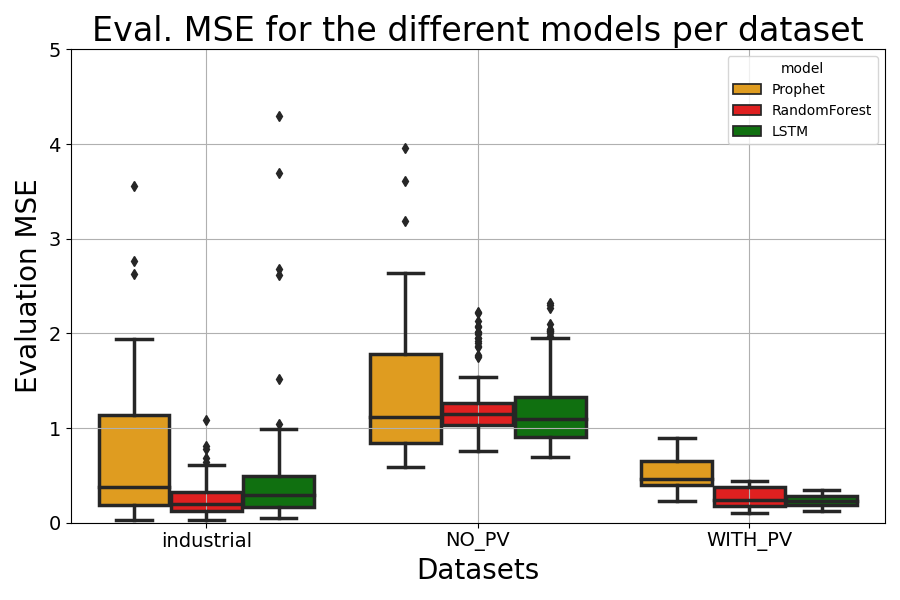

In [7]:
df = COMPLETE_DF.copy(deep=True)

# remove all with ID > 820 (since that's when HPTD)

df = df[df["log_ID"] <= 820]

# remove all that are not Prophet, Random Forest, or LSTM
#df = df[df["model"].isin(["Prophet", "RandomForest", "LSTM", 'NaiveYesterday', 'NaiveLastWeek'])]
df = df[df["model"].isin(["Prophet", "RandomForest", "LSTM"])]

fig, ax = plt.subplots()

ax = sns.boxplot(data=df, x="trinary_classification", y="mse_test", hue="model", palette=COLORS, ax=ax)
ax.grid()
ax.set_title("Eval. MSE for the different models per dataset")
ax.set_ylim([0, 5])
ax.set_ylabel("Evaluation MSE")
ax.set_xlabel("Datasets")
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_MSE_all_with_hue")

# QUALITATIVE ANALYSIS



In [21]:
h = 2
tc = 1
models = ["Prophet", "LSTM", "RandomForest"]
file_ends = ['industrial_2016_LG_20', 'residential_2018_NO_PV_SFH19_2018', 'residential_2018_WITH_PV_SFH15_2018']

df = COMPLETE_DF.copy(deep=True)
df = df[df["horizon"] == h]
df = df[df["time_compression"] == tc]
df = df[df["model"].isin(models)]
df = df[df["file_end"].isin(file_ends)]

df.shape

(9, 70)

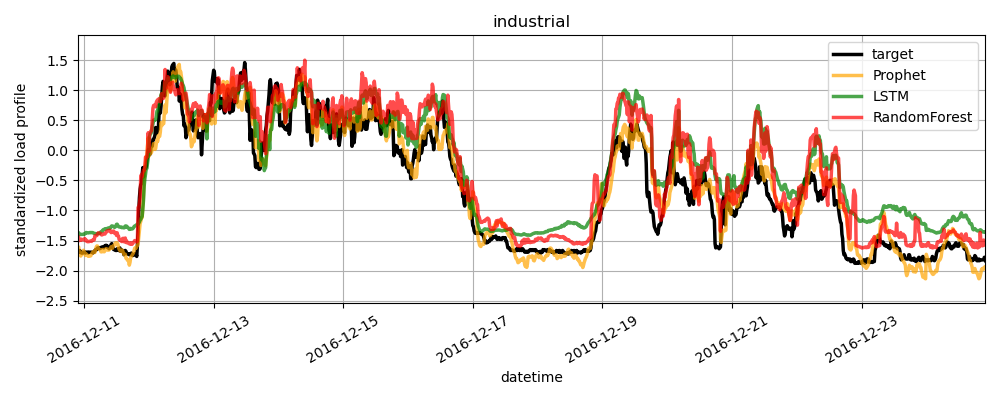

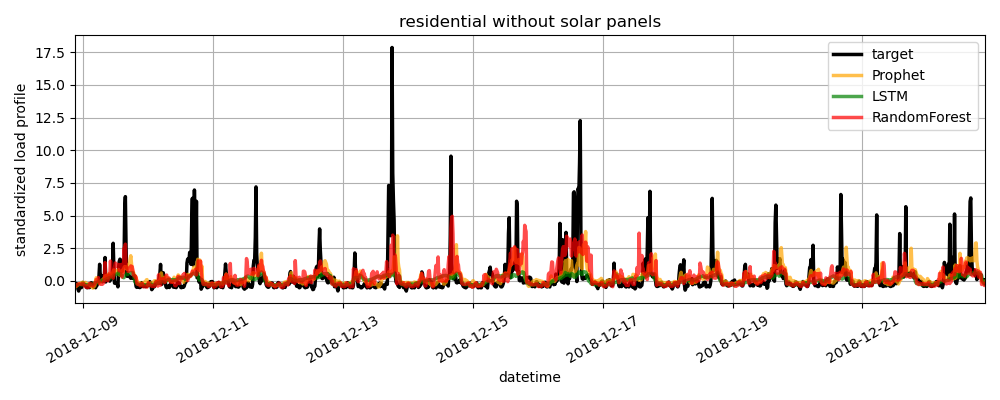

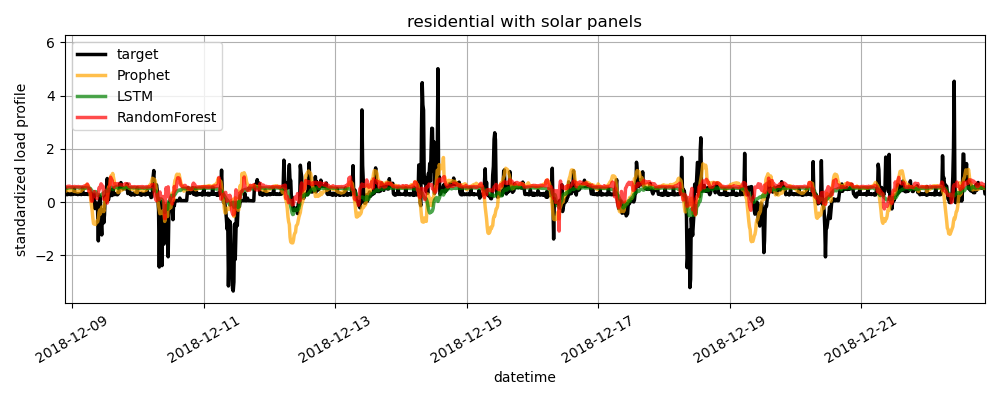

In [22]:
file_ends = ['industrial_2016_LG_20', 'residential_2018_NO_PV_SFH19_2018', 'residential_2018_WITH_PV_SFH15_2018']
for file_end in file_ends:

    fe_df = df[df["file_end"] == file_end]
    assert len(fe_df) == 3
    lower_date = datetime.datetime(1, 1, 1)
    upper_date = datetime.datetime(2500, 1, 1)
    first = True
    fig, ax = plt.subplots(figsize=(10, 4))

    for model in models:
        row = fe_df[fe_df["model"] == model]
        assert len(row) == 1
        
        x = row["test_x"].values[0]
        y = row["test_y"].values[0]
        yhat = row["test_yhat"].values[0]

        if x[0] > lower_date:
            lower_date = x[0]

        if x[-1] < upper_date:
            upper_date = x[-1]

        if first:
            first = False
            ax.plot(x, y, color="black", label="target")
        
        ax.plot(x, yhat, color=COLORS[model], label=model, alpha=0.7)

    upper_date = min(upper_date, lower_date + datetime.timedelta(days=14))

    ax.set_xlim([lower_date, upper_date])
    ax.grid()
    ax.set_xlabel("datetime")
    ax.set_ylabel("standardized load profile")
    ax.legend()

    if "WITH_PV" in file_end:
        title = "residential with solar panels"
        #ax.set_ylim([-2, 2])
    elif "NO_PV" in file_end:
        title = "residential without solar panels"
        #ax.set_ylim([-1, 5])
    elif "industrial" in file_end:
        title = "industrial"
    else:
        raise NotImplementedError
    
    ax.set_title(title)

    plt.setp( ax.xaxis.get_majorticklabels(), rotation=30)
    fig.tight_layout()

    if SAVE_FIGS:
        fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_qualitative_{file_end}")

    




# RFR: Old vs Tuned

In [49]:
df = COMPLETE_DF.copy(deep=True)
df = df[df["time_compression"] == 1]
df = df[df["model"].isin(["RandomForest", "TunedRF"])]
df = df[df["trinary_classification"].isin(['industrial', 'NO_PV', 'WITH_PV'])] # drop aggregate

# remove the files that weren't trained on by both.
all_files = list(df["trained_on"].unique())
bad_files = []
for f in all_files:
    foo = df[df["trained_on"] == f]
    if len(foo) == 1:
        bad_files.append(f)

df = df[~df["trained_on"].isin(bad_files)]

MAP_NAMES = {"RandomForest": "Old RF", "TunedRF": "New RF"}
df["model"] = df["model"].map(MAP_NAMES)

df.shape

(296, 70)

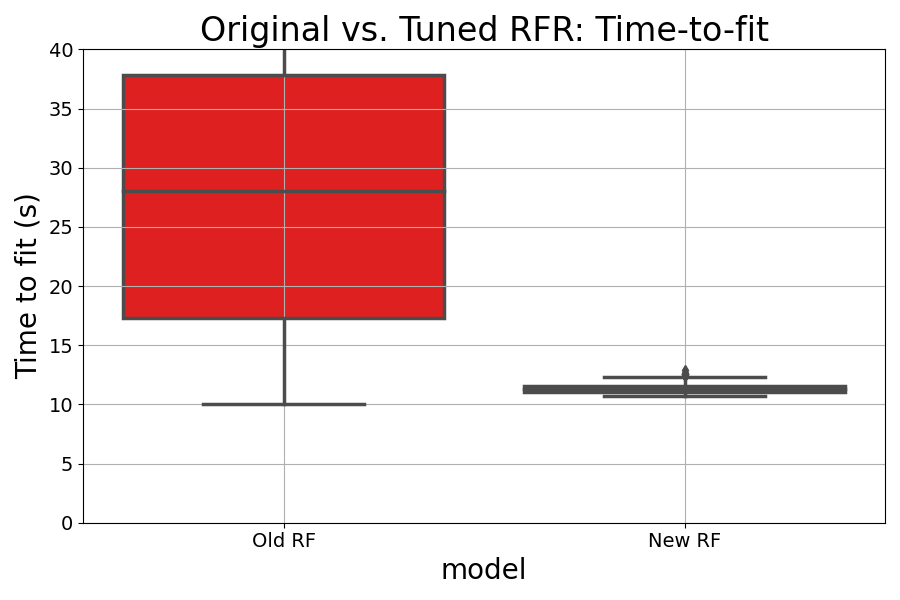

In [51]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="model", y="core_corrected_time_to_fit", palette=COLORS, ax=ax)
ax.grid()
ax.set_ylabel("Time to fit (s)")
ax.set_ylim([0, 40])
ax.set_title("Original vs. Tuned RFR: Time-to-fit")
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_2_ttf")

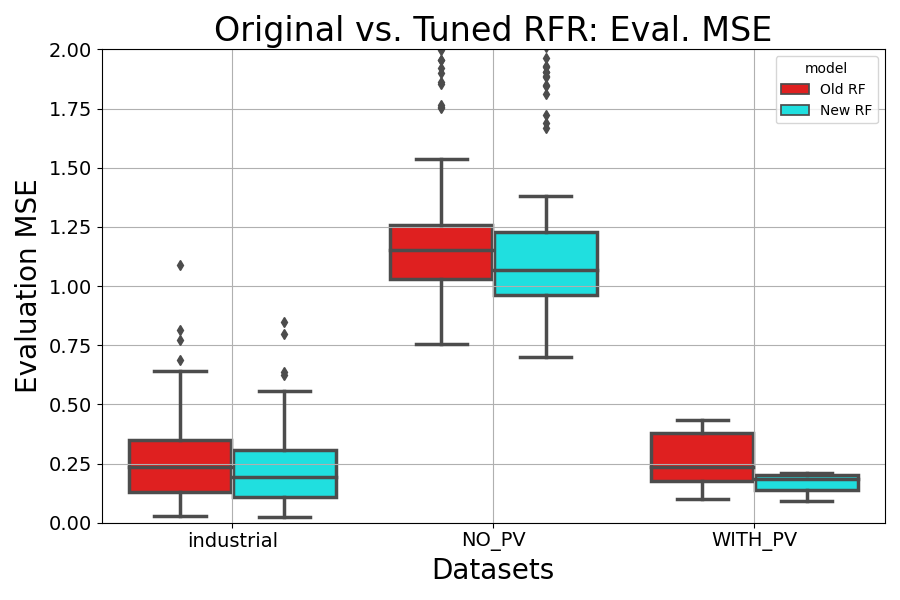

In [53]:
fig, ax = plt.subplots()

ax = sns.boxplot(data=df, x="trinary_classification", y="mse_test", hue="model", palette=COLORS, ax=ax)
ax.grid()
ax.set_ylim([0, 2])
ax.set_title("Original vs. Tuned RFR: Eval. MSE")
ax.set_ylabel("Evaluation MSE")
ax.set_xlabel("Datasets")
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_2_MSE_with_hue")

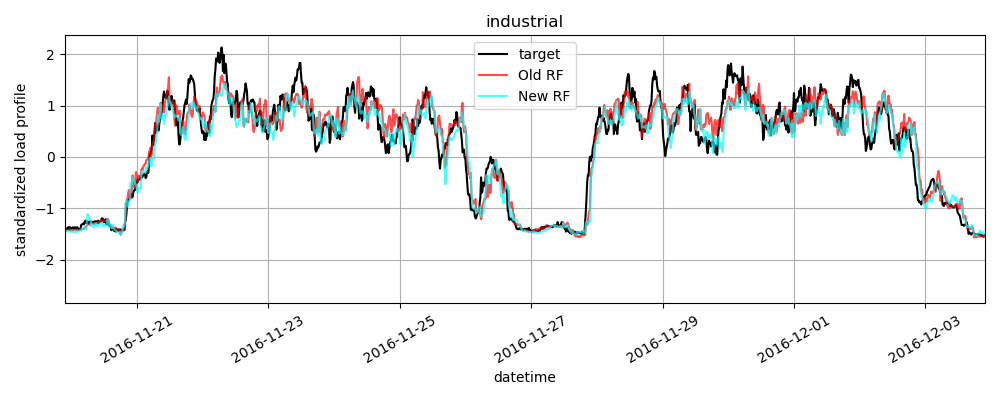

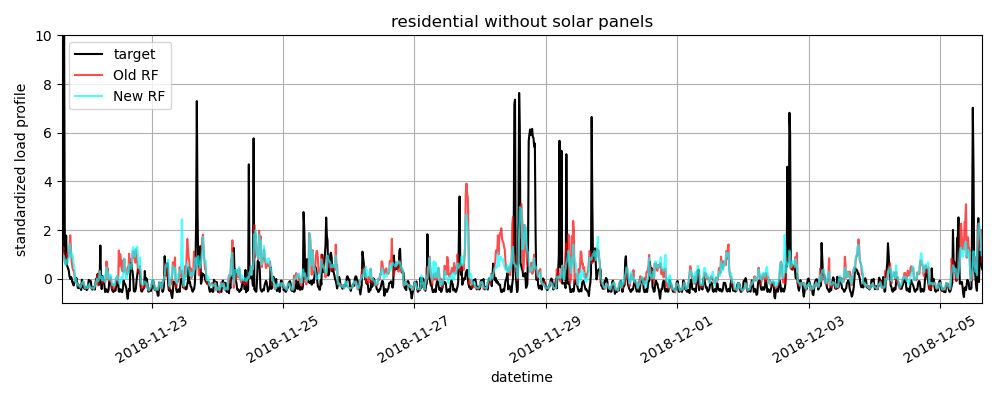

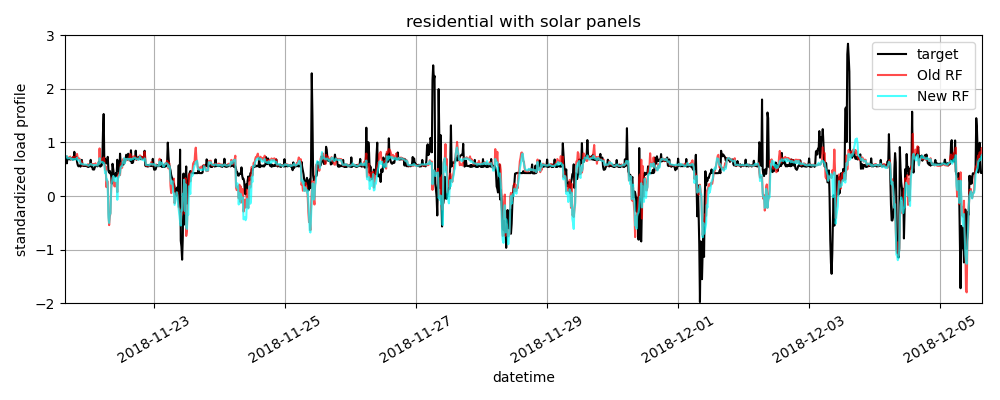

In [24]:
file_ends = ['industrial_2016_LG_20', 'residential_2018_NO_PV_SFH19_2018', 'residential_2018_WITH_PV_SFH15_2018']
models = ["Old RF", "New RF"]
df = df[df["horizon"] == 2]
for file_end in file_ends:

    fe_df = df[df["file_end"] == file_end]
    assert len(fe_df) == 2
    lower_date = datetime.datetime(1, 1, 1)
    upper_date = datetime.datetime(2500, 1, 1)
    first = True
    fig, ax = plt.subplots(figsize=(10, 4))

    for model in models:
        row = fe_df[fe_df["model"] == model]
        assert len(row) == 1
        
        x = row["test_x"].values[0]
        y = row["test_y"].values[0]
        yhat = row["test_yhat"].values[0]

        if x[0] > lower_date:
            lower_date = x[0]

        if x[-1] < upper_date:
            upper_date = x[-1]

        if first:
            first = False
            ax.plot(x, y, color="black", label="target")
        
        ax.plot(x, yhat, color=COLORS[model], label=model, alpha=0.7)

    upper_date = min(upper_date, lower_date + datetime.timedelta(days=14))

    ax.set_xlim([lower_date, upper_date])
    ax.grid()
    ax.set_xlabel("datetime")
    ax.set_ylabel("standardized load profile")
    ax.legend()

    if "WITH_PV" in file_end:
        title = "residential with solar panels"
        ax.set_ylim([-2, 3])
    elif "NO_PV" in file_end:
        title = "residential without solar panels"
        ax.set_ylim([-1, 10])
    elif "industrial" in file_end:
        title = "industrial"
    else:
        raise NotImplementedError
    
    ax.set_title(title)

    plt.setp( ax.xaxis.get_majorticklabels(), rotation=30)
    fig.tight_layout()

    if SAVE_FIGS:
        fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_2_qualitative_{file_end}")

## Tuned RF: Compare prediction horizons

In [7]:
df = COMPLETE_DF.copy(deep=True)
df = df[df["time_compression"] == 1]
df = df[df["model"].isin(["TunedRF"])]
df = df[df["trinary_classification"].isin(['industrial', 'NO_PV', 'WITH_PV'])] # drop aggregate

horizons = list(df["horizon"].unique())
horizons.sort()

# remove the files that weren't trained on by both.
all_files = list(df["file_end"].unique())
bad_files = []
for f in all_files:
    foo = df[df["file_end"] == f]
    if len(foo) < len(horizons):
        bad_files.append(f)

df = df[~df["file_end"].isin(bad_files)]

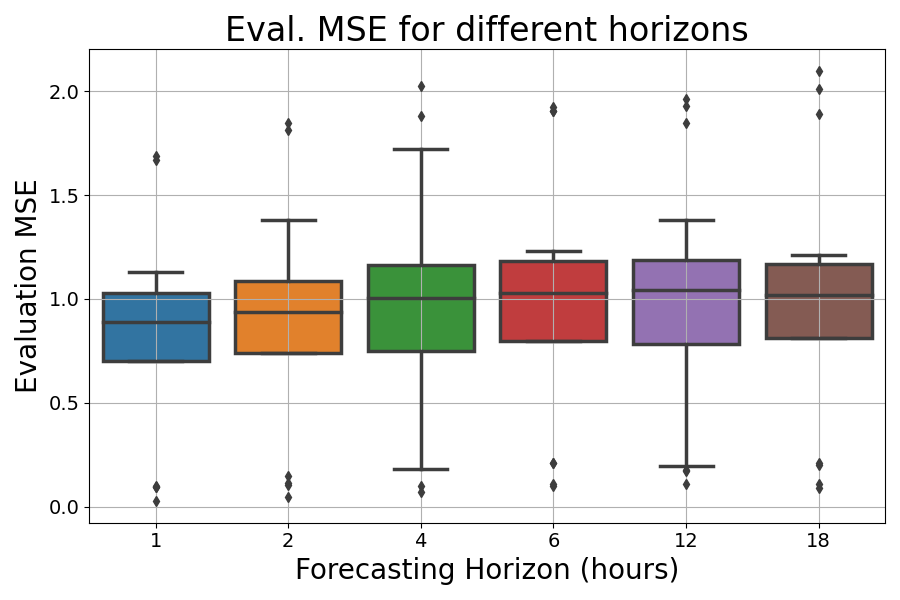

In [56]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="horizon", y="mse_test", order=horizons, ax=ax)
ax.grid()
ax.set_ylabel("Evaluation MSE")
ax.set_xlabel("Forecasting Horizon (hours)")
ax.set_title("Eval. MSE for increasing horizons")
# ax.set_ylim([0.5, 1.5])
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_2_horizon_mse")

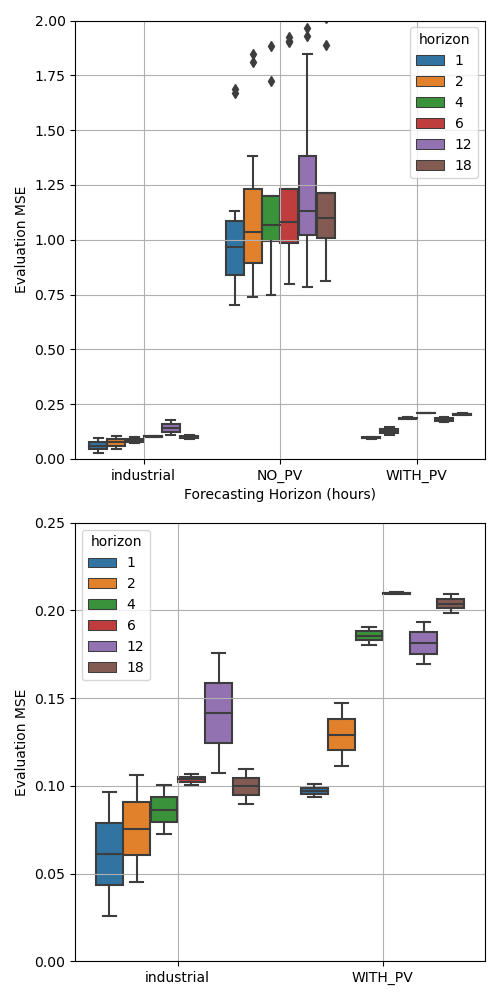

In [51]:
fig, axs = plt.subplots(2, figsize=(5, 10))

ax = axs[0]
ax = sns.boxplot(data=df, x="trinary_classification", hue="horizon", y="mse_test", hue_order=horizons, ax=ax)
ax.grid()
ax.set_ylabel("Evaluation MSE")
ax.set_xlabel("Forecasting Horizon (hours)")
ax.set_ylim([0, 2])
fig.tight_layout()

sdf = df[df["trinary_classification"]!="NO_PV"]
ax = axs[1]
ax = sns.boxplot(data=sdf, x="trinary_classification", hue="horizon", y="mse_test", hue_order=horizons, ax=ax)
ax.grid()
ax.set_ylabel("Evaluation MSE")
ax.set_xlabel(None)
ax.set_ylim([0, 0.25])
fig.tight_layout()


if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_2_horizon_mse_with_hue")

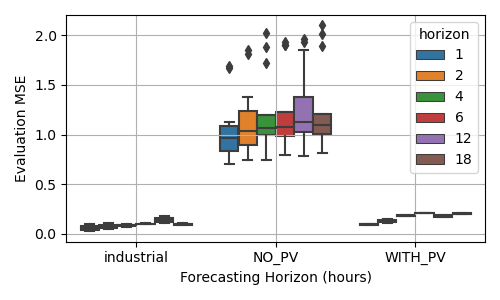

In [244]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="trinary_classification", y="mse_test", hue="horizon", hue_order=horizons, ax=ax)
ax.grid()
ax.set_ylabel("Evaluation MSE")
ax.set_xlabel("Forecasting Horizon (hours)")
#ax.set_ylim([0.5, 1.5])
fig.tight_layout()

In [53]:
4*24*7*20 // 48

280

### Tuned RF: Qualitative performance of horizons

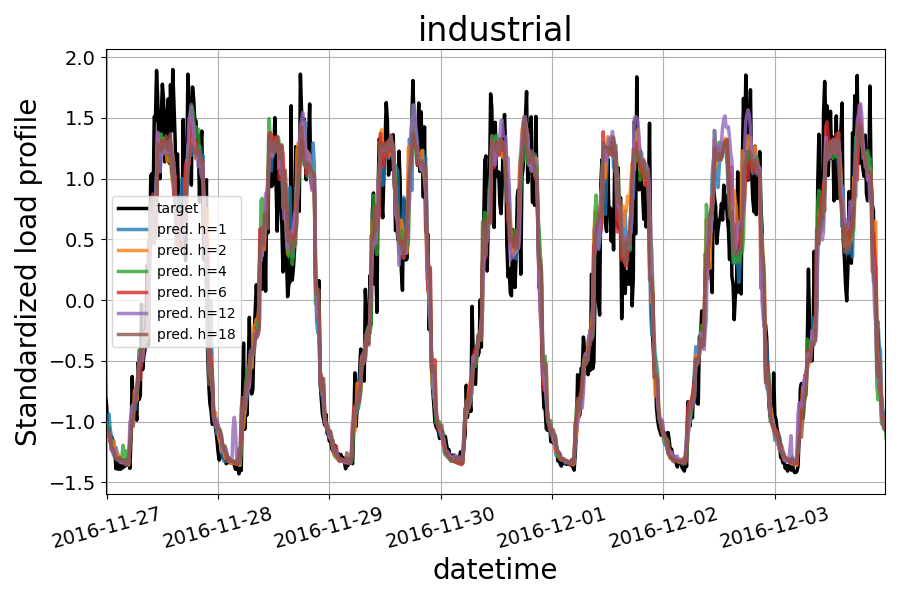

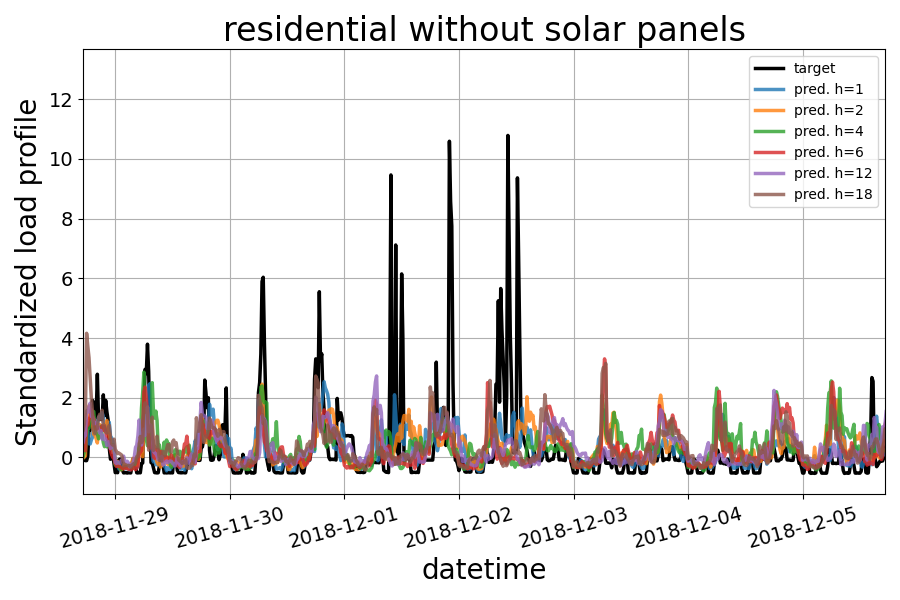

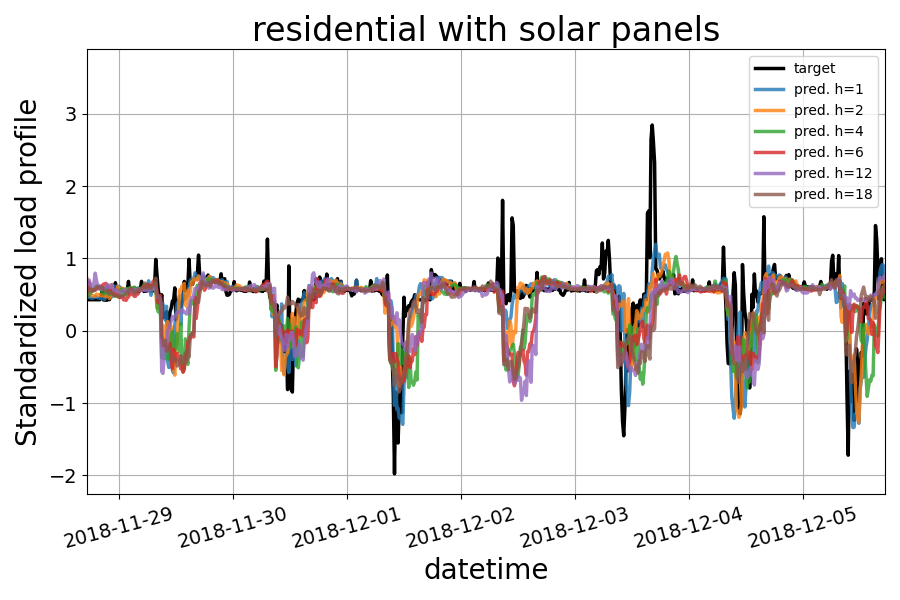

In [11]:
FILE_ENDS = ['industrial_2016_LG_10', 'residential_2018_NO_PV_SFH6_2018', 'residential_2018_WITH_PV_SFH15_2018']


rph = 4 # rows_per_hour

for i, file_end in enumerate(FILE_ENDS):
    fig, ax = plt.subplots()

    sdf = df[df["file_end"] == file_end]
    assert len(sdf) == len(horizons)

    lower_date = datetime.datetime(1, 1, 1)
    upper_date = datetime.datetime(2500, 1, 1)

    first = True

    for h in horizons:
        row = sdf[sdf["horizon"] == h]
        x = row["test_x"].values[0][rph*h:]
        y = row["test_y"].values[0][:-rph*h]
        yhat = row["test_yhat"].values[0][:-rph*h]

        if x[0] > lower_date:
            lower_date = x[0]

        if x[-1] < upper_date:
            upper_date = x[-1]

        if first:
            first = False
            ax.plot(x, y, color="black", label="target")

        ax.plot(x, yhat, label=f"pred. h={h}", alpha=0.8)

    lower_date = lower_date + datetime.timedelta(days=7)
    upper_date = min(upper_date, lower_date + datetime.timedelta(days=7))
    ax.set_xlim([lower_date, upper_date])
    ax.set_ylabel("Standardized load profile")
    ax.grid()

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=15)
    ax.legend()
    ax.set_xlabel("datetime")

    if "industrial" in file_end:
        title = "industrial"
    elif "NO_PV" in file_end:
        title = "residential without solar panels"
    elif "WITH_PV" in file_end:
        title = "residential with solar panels"
    else:
        raise NotImplementedError

    ax.set_title(f"{title}")
    fig.tight_layout()

    if SAVE_FIGS:
        fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_2_horizon_qual_{file_end}")
        




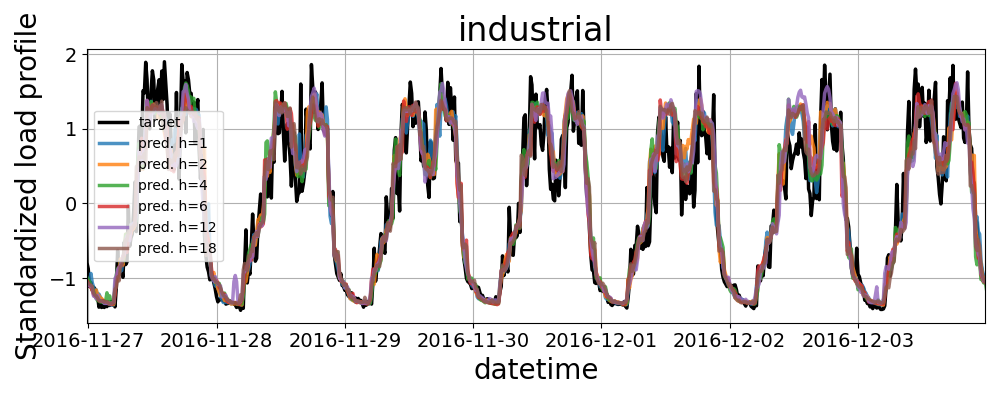

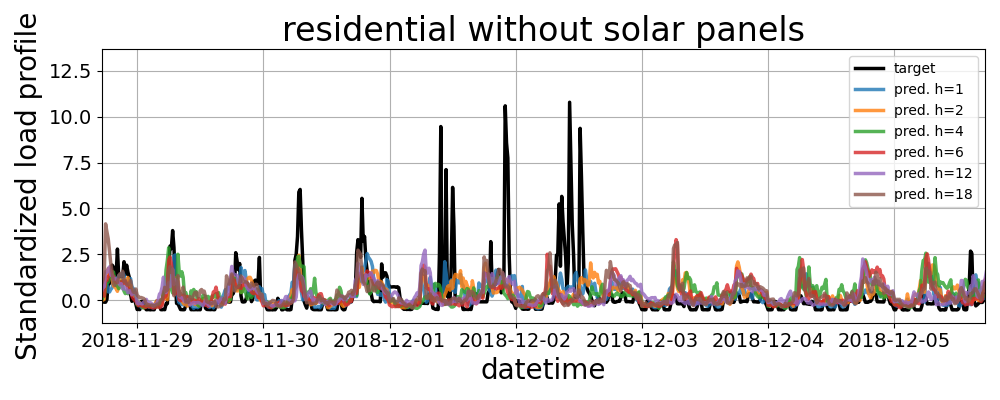

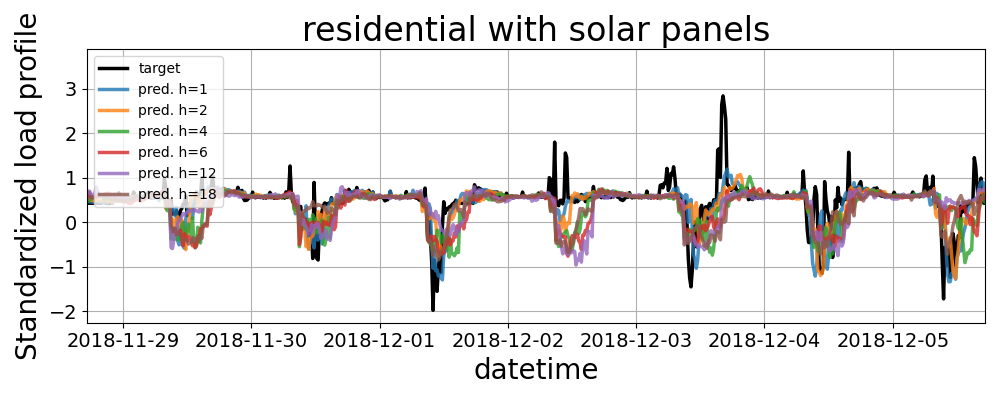

In [10]:
FILE_ENDS = ['industrial_2016_LG_10', 'residential_2018_NO_PV_SFH6_2018', 'residential_2018_WITH_PV_SFH15_2018']



rph = 4 # rows_per_hour

for i, file_end in enumerate(FILE_ENDS):
    sdf = df[df["file_end"] == file_end]
    assert len(sdf) == len(horizons)

    fig, ax = plt.subplots(figsize=(10, 4))

    lower_date = datetime.datetime(1, 1, 1)
    upper_date = datetime.datetime(2500, 1, 1)

    first = True

    for h in horizons:
        row = sdf[sdf["horizon"] == h]
        x = row["test_x"].values[0][rph*h:]
        y = row["test_y"].values[0][:-rph*h]
        yhat = row["test_yhat"].values[0][:-rph*h]

        if x[0] > lower_date:
            lower_date = x[0]

        if x[-1] < upper_date:
            upper_date = x[-1]

        if first:
            first = False
            ax.plot(x, y, color="black", label="target")

        ax.plot(x, yhat, label=f"pred. h={h}", alpha=0.8)

    lower_date = lower_date + datetime.timedelta(days=7)
    upper_date = min(upper_date, lower_date + datetime.timedelta(days=7))
    ax.set_xlim([lower_date, upper_date])
    ax.set_ylabel("Standardized load profile")
    ax.grid()

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    ax.legend()
    ax.set_xlabel("datetime")

    if "industrial" in file_end:
        title = "industrial"
    elif "NO_PV" in file_end:
        title = "residential without solar panels"
    elif "WITH_PV" in file_end:
        title = "residential with solar panels"
    else:
        raise NotImplementedError

    ax.set_title(f"{title}")
    fig.tight_layout()

    if SAVE_FIGS:
        fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_2_horizon_qual_{title}")
        




## Compare longer sampling period

In [66]:
df = COMPLETE_DF[COMPLETE_DF["model"] == 'TunedRF']
df = df[~df["trinary_classification"].isin(["aggregate"])]
df = df[df["horizon"] == 18]

In [58]:
time_compressions = list(df['time_compression'].unique())
time_compressions.sort()

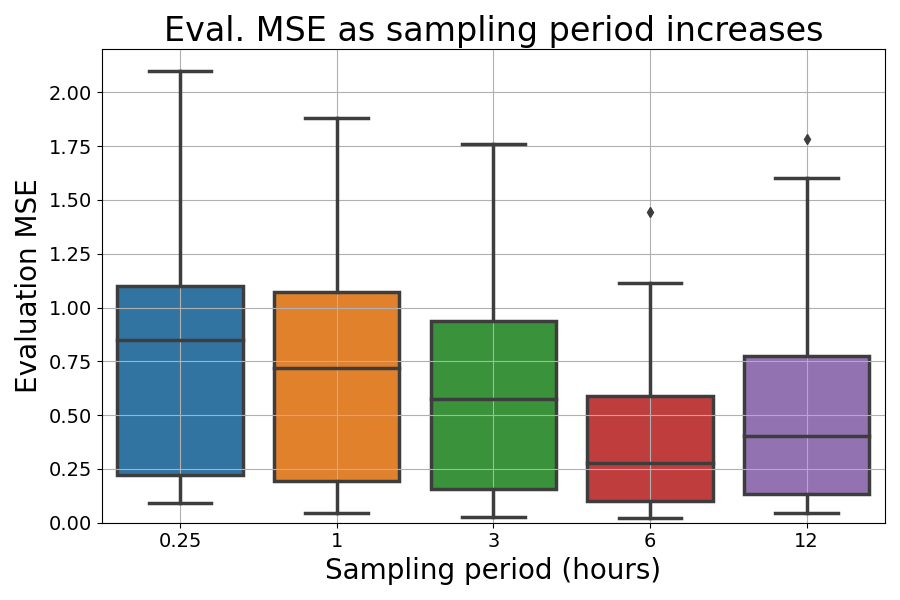

In [59]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="time_compression", y="mse_test", ax=ax)
ax.grid()
ax.set_ylabel("Evaluation MSE")
ax.set_title("Eval. MSE as sampling period increases")
ax.set_xlabel("Sampling period (hours)")
ax.set_xticklabels([0.25, 1, 3, 6, 12])
ax.set_ylim([0, 2.2])
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_3_mse")

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (5).

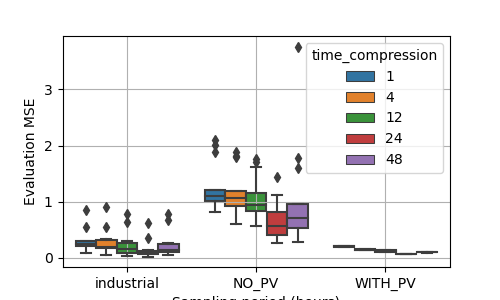

In [124]:
# fig, ax = plt.subplots()
# ax = sns.boxplot(data=df, x="trinary_classification", y="mse_test", hue="time_compression", ax=ax)
# ax.grid()
# ax.set_ylabel("Evaluation MSE")
# ax.set_xlabel("Sampling period (hours)")
# ax.set_xticklabels([0.25, 1, 3, 6, 12])
# ax.set_ylim([0, 2.2])
# fig.tight_layout()

# # if SAVE_FIGS:
# #     fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_3_mse_with_hue")

### Time compression: qualitative analysis

(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)
(1, 70)


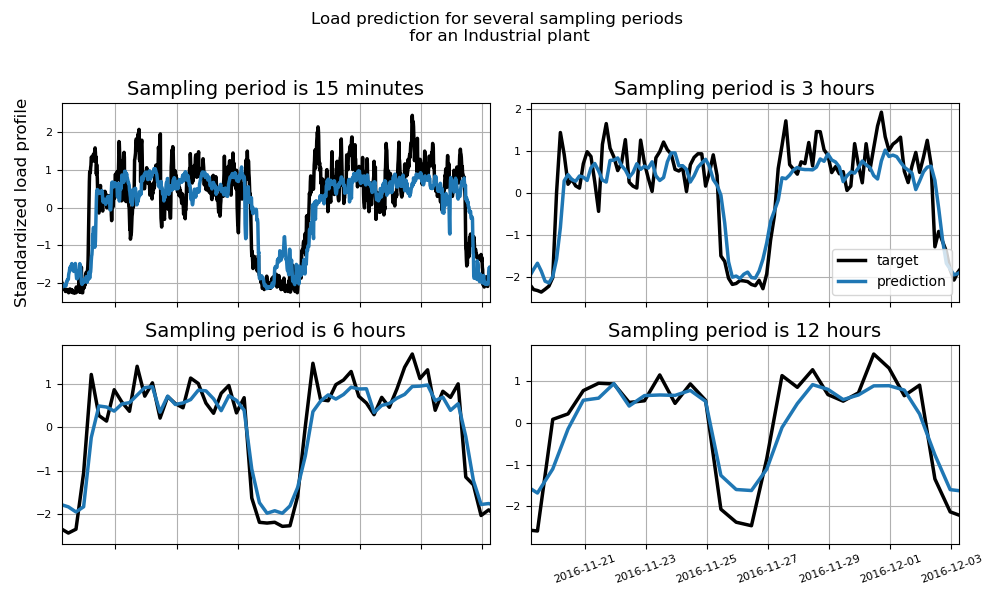

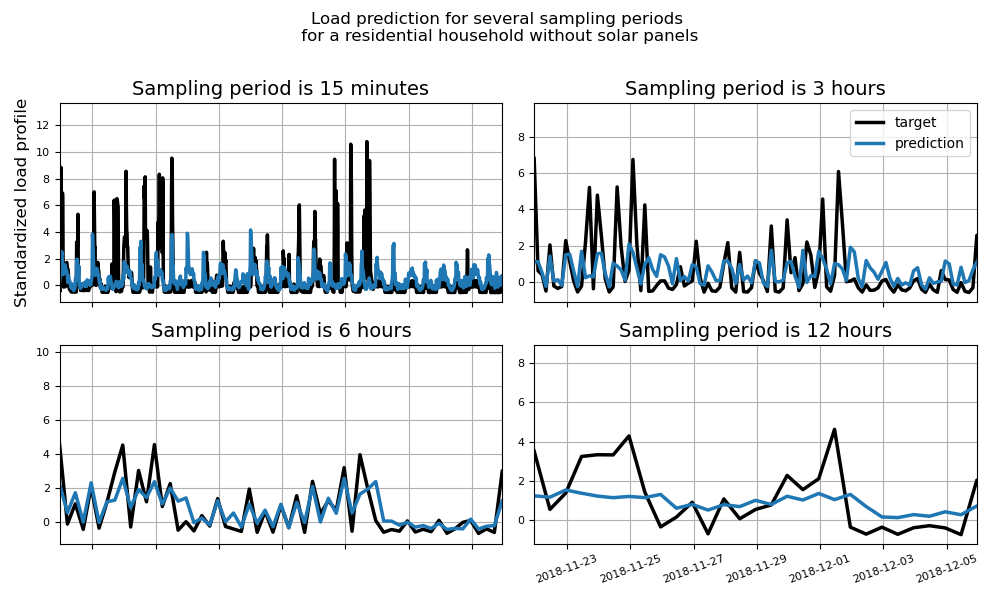

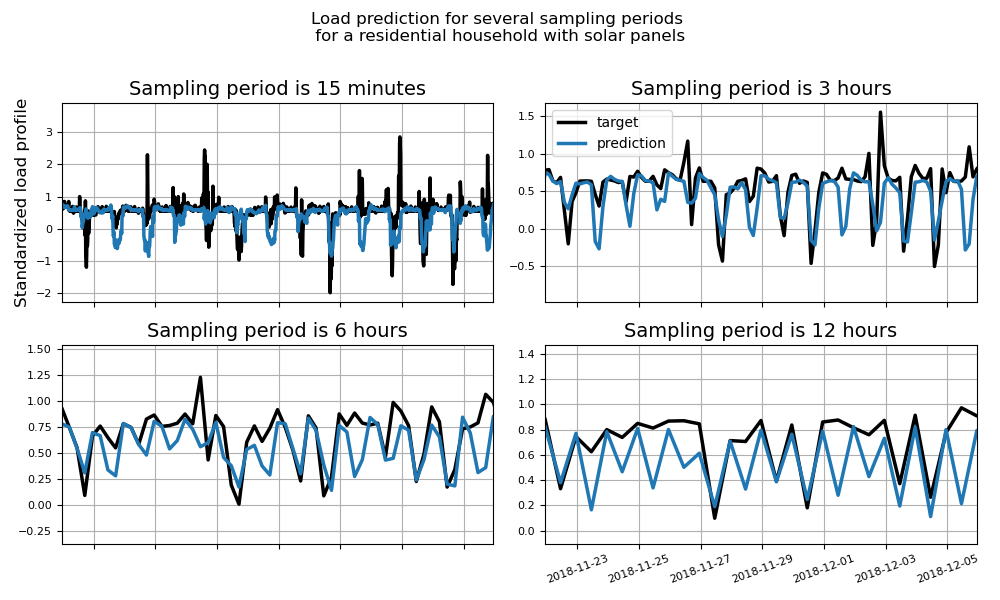

In [77]:
SAMPLING_PERIODS = {1: "15 minutes", 4: "1 hour", 12: "3 hours", 24: "6 hours", 48: "12 hours"}
regex_strings = ["industrial_2016_LG.*_8", 'residential_2018_NO_PV_SFH6.*_2018', 'residential_2018_WITH_PV_SFH15.*_2018']
used_tcs = [1, 12, 24, 48]

## Original settings
# mpl.rcParams["lines.linewidth"] = 2.5
# mpl.rcParams["figure.figsize"] = (9, 6)
# mpl.rcParams["axes.titlesize"] = 24
# mpl.rcParams["axes.labelsize"] = 20
# mpl.rcParams["xtick.labelsize"] = 14
# mpl.rcParams["ytick.labelsize"] = 14

mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8


for reg_str in regex_strings:
    sub_df = df[df["file_end"].str.contains(reg_str)]
    sub_df = sub_df.sort_values(by="time_compression")

    fig, _axs = plt.subplots(2, 2)
    axs = [_axs[0,0], _axs[0,1], _axs[1,0], _axs[1,1]]

    lower_date = datetime.datetime(1, 1, 1)
    upper_date = datetime.datetime(2500, 1, 1)

    for i, tc in enumerate(used_tcs):
        row = sub_df[sub_df["time_compression"] == tc]
        print(row.shape)
        
        assert len(row) == 1

        x = row["test_x"].values[0]
        y = row["test_y"].values[0]
        yhat = row["test_yhat"].values[0]

        if x[0] > lower_date:
            lower_date = x[0]

        if x[-1] < upper_date:
            upper_date = x[-1]

        axs[i].plot(x, y, color="black", label="target")
        axs[i].plot(x, yhat, label="prediction")
        axs[i].set_title(f"Sampling period is {SAMPLING_PERIODS[tc]}")

    for ax in axs:
        upper_date = min(upper_date, lower_date + datetime.timedelta(days=14))
        ax.set_xlim([lower_date, upper_date])
        
        
        ax.grid()

        plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=20)
    
    for ax in axs[:-1]:
        ax.xaxis.set_ticklabels([])
        
    axs[1].legend()
    axs[0].set_ylabel("Standardized load profile")
    #axs[-1].set_xlabel("datetime")

    if "industrial" in reg_str:
        fig.suptitle("Load prediction for several sampling periods \n for an Industrial plant \n")
    elif "NO_PV" in reg_str:
        fig.suptitle("Load prediction for several sampling periods \n for a residential household without solar panels \n")
    elif "WITH_PV" in reg_str:
        fig.suptitle("Load prediction for several sampling periods \n for a residential household with solar panels \n")
    else:
        raise NotImplementedError

    fig.tight_layout()

    if SAVE_FIGS:
        file_end = reg_str.split(".")[0]
        fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_3_qual_{file_end}")



# Aggregation

In [78]:
df = COMPLETE_DF[COMPLETE_DF["trinary_classification"].isin(["NO_PV", "aggregate"])]

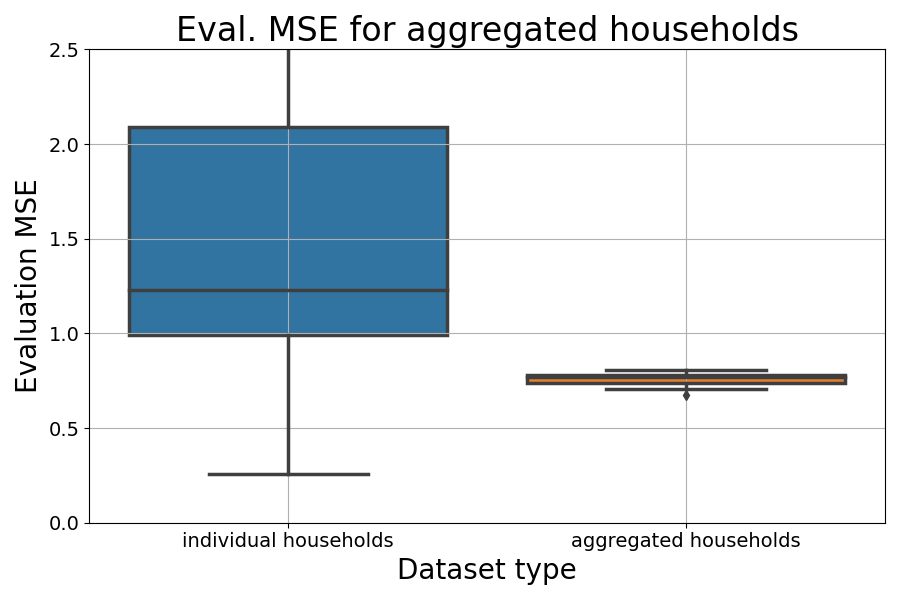

In [62]:


fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="trinary_classification", y="mse_test", ax=ax)
ax.grid()
ax.set_ylabel("Evaluation MSE")
ax.set_title("Eval. MSE for aggregated households")
ax.set_xlabel("Dataset type")
ax.set_xticklabels(["individual households", "aggregated households"])
ax.set_ylim([0, 2.5])
fig.tight_layout()

if SAVE_FIGS:
    fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_3_aggr_mse")

## Aggregate qualitative

(12, 70) (2, 70) (1, 70)


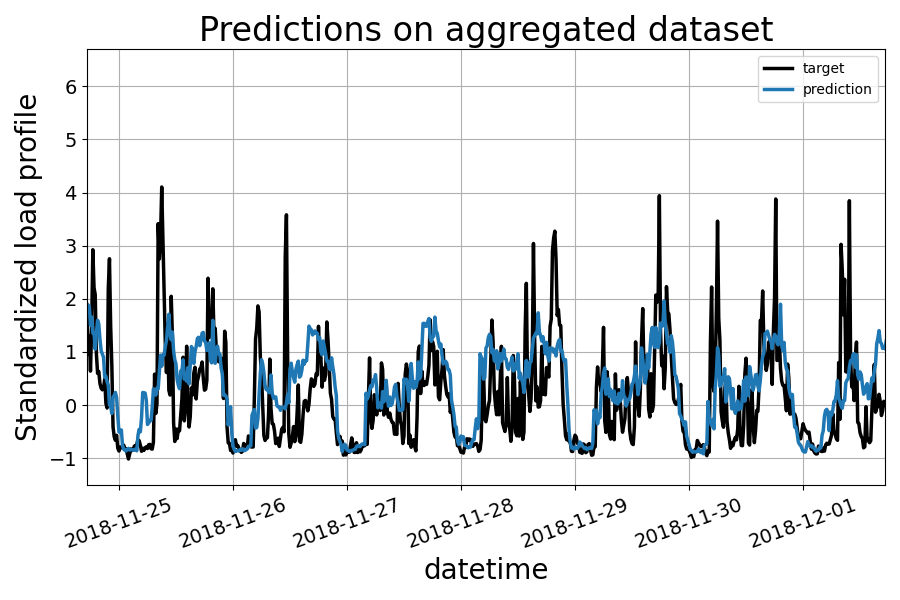

In [82]:
# Original settings
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["figure.figsize"] = (9, 6)
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14


horizons = [1]
years = [2018]
for year in years:
    fig, axs = plt.subplots(len(horizons))
    if len(horizons) == 1:
        axs = [axs]

    lower_date = datetime.datetime(1, 1, 1)
    upper_date = datetime.datetime(2500, 1, 1)

    for i, h in enumerate(horizons):
        adf = df[df["trinary_classification"] == "aggregate"]
        hdf = adf[adf["horizon"] == h]
        sub_df = hdf[hdf["file_end"].str.endswith(f"{year}")]

        print(adf.shape, hdf.shape, sub_df.shape)
        assert len(sub_df) == 1

        sub_df = sub_df.copy(deep=True)

        x = sub_df["test_x"].values[0] 
        yhat = sub_df["test_yhat"].values[0]
        # y = list(sub_df["test_y"])
        y = sub_df["test_y"].copy(deep=True).values[0]

        if x[0] > lower_date:
            lower_date = x[0]

        if x[-1] < upper_date:
            upper_date = x[-1]

        axs[i].plot(x, y, color="black", label="target")
        axs[i].plot(x, yhat, label="prediction")
        axs[i].set_title(f"Predictions on aggregated dataset")

    upper_date = min(upper_date, lower_date + datetime.timedelta(days=7))
    for ax in axs:
        ax.set_xlim([lower_date, upper_date])
        ax.set_ylabel("Standardized load profile")
        ax.grid()

    plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=20)
    axs[0].legend()
    axs[-1].set_xlabel("datetime")

    fig.tight_layout()

    if SAVE_FIGS:
        fig.savefig(FIGURE_SAVE_DIR / f"{FIG_TYPE}_res_3_qual_aggr")

In [254]:
hdf.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'weekly_seasonality', 'daily_seasonality',
       'only_fit_using_last_n_weeks', 'rolling_predict_rows_to_refit',
       'n_cores', 'rolling_prediction', 'tiny_test', 'os', 'time_at_saving',
       'log_name', 'trained_on', 'log_ID', 'file_end', 'binary_classification',
       'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
       'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'error',
       'error_mean', 'error_std', 'test_error', 'test_error_mean',
       'test_error_std', 'train_error', 'train_error_mean', 'train_error_std',
       'r2', 'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
       'time_compression', 'n_estimators', 'n_jobs', 'max_features',
       'max_samples', 'ts2row_history_window', 'n_train_epoc

In [166]:
sub_df = sub_df[sub_df["file_end"].str.contains(str(2018))]

In [167]:
sub_df

time_before_fit  time_to_fit  \
1056  'Fri Nov 25 11:17:48 2022'      3.75084   

                                                      x  \
1056  DatetimeIndex(['2018-09-02 22:00:00', '2018-09...   

                                                      y  time_to_predict  \
1056  [-0.20099804896037102, -0.5881473628611561, -0...        22.768287   

                                                   yhat  \
1056  [-0.1918471565467395, -0.38501557186200464, -0...   

                                               features  \
1056  [year, month_sines, month_cosines, hour_sines,...   

                                     data_source_path  horizon    model  ...  \
1056  datasets\test\aggregate\h=18_aggregate_2018.csv       18  TunedRF  ...   

      n_train_epochs  learning_rate  learning_rate_scheduler_enabled  \
1056             NaN            NaN                              NaN   

      learning_rate_decay_factor  window_size  swa_enabled  swa_start  \
1056                         NaN          NaN          NaN        NaN   

      SARIMAX_max_iter SARIMAX_order SARIMAX_seasonal_order  
1056               NaN           NaN                    NaN  

[1 rows x 70 columns]

In [248]:
df['only_fit_using_last_n_weeks'].unique()

array([20.])

In [253]:
20*7*24*4

13440

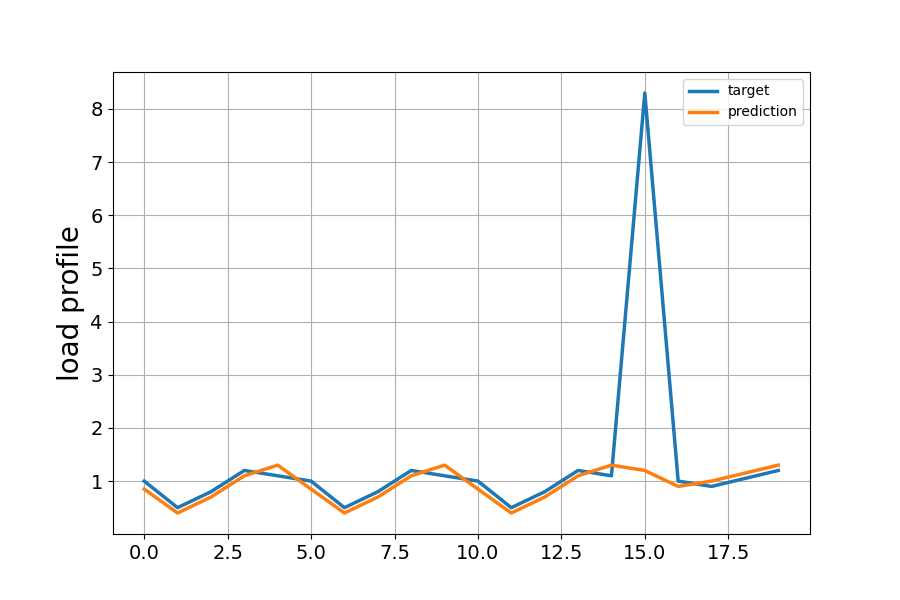

In [87]:
y = [1, 0.5, 0.8, 1.2, 1.1, 1, 0.5, 0.8, 1.2, 1.1, 1, 0.5, 0.8, 1.2, 1.1, 8.3, 1, 0.9, 1.05, 1.2]
yh = [0.85, 0.4, 0.7, 1.1, 1.3, 0.85, 0.4, 0.7, 1.1, 1.3,0.85, 0.4, 0.7, 1.1, 1.3, 1.2, 0.9, 1, 1.15, 1.3]

fig, ax = plt.subplots()

ax.plot(y, label="target")
ax.plot(yh, label="prediction")

ax.set_ylabel("load profile")
ax.grid()
ax.legend()